This notebook will be used to take data and find the best way to summarize and visualize before performing inferential analysis.

In [80]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
"""" This module contains all the functions used in the main.py file.  It takes in a
    list of products and creates dataframes of each, with the name as the key and daily
    price information as the value.  These functions also put the data into clean
    format in order to then insert both the product symbols and the price data into
    a SQLite3 database.
"""

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime
import quandl
import sqlite3

def create_df_crypto(symbol, curr='USD', limit=2000):
    ''' This function takes in a symbol of a cryptocurrency to be
        used with the Cryptocompare API, and returns a formatted dataframe
        for later processing.

        Args: symbol - cryptocurrency symbol
              curr - currency to report in (default USD)
              limit - max number of data points (default 2500)

        Return: df - dataframe of daily price info for symbol
    '''
    # Set url and params for the call to Cryptocompare API
    url = 'https://min-api.cryptocompare.com/data/histoday'
    params = {'fsym': symbol, 'tsym': curr, 'limit': limit}

    # Call API for symbol and put data into pandas dataframe
    response = requests.get(url, params=params)
    data = response.json()['Data']
    df = pd.DataFrame(data)

    # Add date column and set to index
    df['Date'] =[datetime.date.fromtimestamp(d) for d in df.time]
    df = df[['open', 'high', 'low', 'close', 'volumeto', 'Date']]
    df.set_index('Date', inplace=True)

    # Rename volumeto column
    df.rename(columns={'volumeto': 'volume'}, inplace=True)

    return df

def create_df_quandl(symbol, api_key):
    ''' This function takes in a symbol of a futures contract to be used
        with the Quandl API as well as the API key, and returns a formatted
        dataframe for processing.

        Args: symbol - a symbol for a continuous futures contract
              api_key - Quandl API key

        Return: df - dataframe for daily price info for symbol
    '''
    # Quandl API call which puts price data into dataframe
    df = quandl.get('SCF/CME_{s}1_FW'.format(s=symbol), authtoken=api_key)

    # Drop open interest column and rename Settle column
    df.drop(['Prev. Day Open Interest'], axis=1, inplace=True)
    df.rename(columns={'Open': 'open',
                      'High': 'high',
                      'Low': 'low',
                      'Settle': 'close',
                      'Volume': 'volume'}, inplace=True)
    return df

def clean_df_crypto(df, volume_thresh=1000000):
    ''' This function takes in a dataframe and a volume threshold and returns a filtered
        dataframe from the first data point that achieves the threshold.  This is written
        to be used specifically with the cryptocurrency dataframes.

        Args: df - dataframe to be filtered on volume
              volume_thresh - min volume to reach before using data in the dataframe

        Return df - the filtered dataframe with only points after the volume threshold is hit
    '''
    # Find start_date and filter df
    start_date = df.index[df.volume > volume_thresh].tolist()[0]
    df = df[start_date:]

    return df

def replace_df_zeros(df):
    ''' This function takes in a dataframe of price information, finds all zero values
        for the 'volume' column and replaces them with the mean volume of the dataset.

        Args: df - dataframe of price information

        Return: df - cleaned dataframe with no zero volume entries
    '''
    df['volume'].replace(0.0, df['volume'].mean(), inplace=True)

    return df

def check_outliers(df):
    ''' This function finds all closing price points that are more than 3 stds away from
        the mean and plots them on a line graph of all the data.  This can be used to see
        if these points are truly outliers.

        Args: df - dataframe to be checked for outliers

        Return: None - shows a graph of the price data series with annotations for outliers
    '''
    # Use a copy of the dataframe
    cpy = df.copy()
    # Create range of values that are more than 3 stds away from mean
    cpy['stds_from_mean'] = ((cpy['close'] - cpy['close'].mean()).apply(abs)) / cpy['close'].std()
    locs_gt_3std = [cpy.index.get_loc(x) for x in cpy.index[cpy['stds_from_mean'] > 3.0]]

    # Plot the price data, highlighting the outliers
    plt.figure(figsize=(15,10))
    plt.plot(cpy.index, cpy.close, linestyle='solid', markevery=locs_gt_3std,
                marker='o', markerfacecolor='r', label='Outliers')

    # Apply title, legend and labels
    plt.title('Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()

    plt.show()

    # Print out description
    print('Number of data points: {}'.format(len(cpy.index)))
    print('Number of outliers: {}'.format(len(locs_gt_3std)))

def generate_df_dict(product_dict, api_key=None):
    ''' This function takes in a dict of product symbols mapped to
        information about the product  and a Quandl API key and returns
        a dict object with the symbols as keys and a dataframe of price
        info as values.

        Args: product_dict - a dict of symbols for products with maps to
                             a list of info
              api_key - Quandl API key

        Return: df_dict - a dictionary of symbols mapped to dataframes
                          of price info
    '''
    df_dict = {}

    # Iterate through list
    for product, info in product_dict.items():
        # Determine what dataframe creator to use
        if info[0] == 1:
            df = create_df_crypto(product)
            df = clean_df_crypto(df)
            df = replace_df_zeros(df)
        if info[0] == 2:
            df = create_df_quandl(product, api_key)
            df = replace_df_zeros(df)

        df_dict[product] = df

    return df_dict

In [3]:
api_key = 'Hv95pPh1xQWzt5DFhxS7'

In [4]:
products = {'CL': [2, 'Crude', 'Energy', 'CME'],
                'HO': [2, 'HeatOil', 'Energy', 'CME'],
                'NG': [2, 'NatGas', 'Energy', 'CME'],
                'GC': [2, 'Gold', 'Metals', 'CME'],
                'SI': [2, 'Silver', 'Metals', 'CME'],
                'AD': [2, 'Aussie', 'Forex', 'CME'],
                'CD': [2, 'Canadien', 'Forex', 'CME'],
                'EC': [2, 'Euro', 'Forex', 'CME'],
                'BP': [2, 'Pound', 'Forex', 'CME'],
                'JY': [2, 'Yen', 'Forex', 'CME'],
                'US': [2, '30-yr', 'Treasuries', 'CME'],
                'C': [2, 'Corn', 'Grains', 'CME'],
                'W': [2, 'Wheat', 'Grains', 'CME'],
                'S': [2, 'Soybeans', 'Grains', 'CME'],
                'ES': [2, 'E-mini', 'Indexes', 'CME'],
                'BTC': [1, 'Bitcoin', 'Cryptocurrency', 'CCAgg'],
                'ETH': [1, 'Ethereum', 'Cryptocurrency', 'CCAgg'],
                'XRP': [1, 'Ripple', 'Cryptocurrency', 'CCAgg'],
                'BCH': [1, 'BitcoinCash', 'Cryptocurrency', 'CCAgg'],
                'LTC': [1, 'Litecoin', 'Cryptocurrency', 'CCAgg'],
                'ADA': [1, 'Cardano', 'Cryptocurrency', 'CCAgg'],
                'NEO': [1, 'Neo', 'Cryptocurrency', 'CCAgg'],
                'XLM': [1, 'Stellar', 'Cryptocurrency', 'CCAgg'],
                'EOS': [1, 'EOS', 'Cryptocurrency', 'CCAgg'],
                'XMR': [1, 'Monero', 'Cryptocurrency', 'CCAgg'],}

In [5]:
df_dict = generate_df_dict(products, api_key)

In [6]:
emini = df_dict['ES']
emini.head()

,open,high,low,close,volume
Date,,,,,
2005-01-03,1213.50,1221.25,1201.75,1206.25,672360.0
2005-01-04,1206.25,1209.50,1186.75,1191.00,869562.0
2005-01-05,1190.75,1195.00,1182.75,1183.25,855689.0
2005-01-06,1183.25,1193.75,1182.75,1188.25,678414.0
2005-01-07,1188.50,1194.50,1183.50,1186.25,766197.0


In [7]:
def vol_bo(row, direction):
    ''' This is a helper function to use in volume breakout column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if row['volume'] > (2 * row['20day_ave_vol']):
        if (direction == 'long') and (row['close_gt_prev_h'] > 0.0):
            return 1
        elif (direction == 'short') and (row['close_lt_prev_l'] < 0.0):
            return 1
        else:
            return 0

def range_bo(row, direction):
    ''' This is a helper function to use in range breakout column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['high'] > row['20day_high']:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['low'] < row['20day_low']:
            return 1
        else:
            return 0

def ma_signal(row, ma, direction):
    ''' This is a helper function to use in all moving average columns creation.  It takes
        in a row of a dataframe, a length of time and a direction of trade, and returns
        1 if a breakout has occured, 0 if not.

        Args: row - row of a dataframe
              ma - length of time for moving average
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['close'] > row['ma{}'.format(ma)]:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['close'] < row['ma{}'.format(ma)]:
            return 1
        else:
            return 0

def bb_signal(row, direction):
    ''' This is a helper function to use in all bollinger band column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['low'] < row['bb_low']:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['high'] > row['bb_high']:
            return 1
        else:
            return 0

def add_all_indicators(df):
    ''' This function takes in a cleaned dataframe of price information and uses
        the helper functions to add all relevant indicators as columns
        to the dataframe.

        Args: df - cleaned dataframe of price information

        Return: df - cleaned dataframe with added columns for all indicators
    '''
    # All columns for 20day volume breakout indicator
    df['20day_ave_vol'] = df.volume.rolling(window=20, center=False).mean().shift(1)
    df['close_gt_prev_h'] = df['close'] - df['high'].shift(1)
    df['close_lt_prev_l'] = df['close'] - df['low'].shift(1)
    df['vol_bo_long'] = df.apply(lambda row: vol_bo(row, direction='long'), axis=1)
    df['vol_bo_short'] = df.apply(lambda row: vol_bo(row, direction='short'), axis=1)
    df['vol_bo_long'].fillna(value=0, inplace=True)
    df['vol_bo_short'].fillna(value=0, inplace=True)

    # All columns for 20day range breakout indicator
    df['20day_high'] = df.high.rolling(window=20, center=False).max().shift(1)
    df['20day_low'] = df.low.rolling(window=20, center=False).min().shift(1)
    df['range_bo_long'] = df.apply(lambda row: range_bo(row, direction='long'), axis=1)
    df['range_bo_short'] = df.apply(lambda row: range_bo(row, direction='short'), axis=1)

    # All columns for moving average indicators
    df['ma20'] = df['close'].rolling(window=20, center=False).mean()
    df['ma50'] = df['close'].rolling(window=50, center=False).mean()
    df['ma100'] = df['close'].rolling(window=100, center=False).mean()
    df['ma20_long'] = df.apply(lambda row: ma_signal(row, ma=20, direction='long'), axis=1)
    df['ma20_short'] = df.apply(lambda row: ma_signal(row, ma=20, direction='short'), axis=1)
    df['ma50_long'] = df.apply(lambda row: ma_signal(row, ma=50, direction='long'), axis=1)
    df['ma50_short'] = df.apply(lambda row: ma_signal(row, ma=50, direction='short'), axis=1)
    df['ma100_long'] = df.apply(lambda row: ma_signal(row, ma=100, direction='long'), axis=1)
    df['ma100_short'] = df.apply(lambda row: ma_signal(row, ma=100, direction='short'), axis=1)

    # All columns for bollinger band indicators
    df['bb_high'] = df['ma20'] + (2 * df['close'].rolling(window=20, center=False).std())
    df['bb_low'] = df['ma20'] - (2 * df['close'].rolling(window=20, center=False).std())
    df['bb_long'] = df.apply(lambda row: bb_signal(row, direction='long'), axis=1)
    df['bb_short'] = df.apply(lambda row: bb_signal(row, direction='short'), axis=1)

    # All columns for percentage change for timeframe into the future
    df['pct_change_1day'] = df['close'].pct_change()
    df['pct_change_5day'] = df['close'].pct_change(periods=5)
    df['pct_change_10day'] = df['close'].pct_change(periods=10)
    df['pct_change_20day'] = df['close'].pct_change(periods=20)

    return df

In [8]:
emini = add_all_indicators(emini)
emini.tail()

,open,high,low,close,volume,20day_ave_vol,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,...,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-24,2078.75,2083.50,2077.00,2078.75,235054.0,1263141.32,-5.75,7.25,0.0,0.0,...,1,0,2111.738883,1976.291117,0,0,-0.000120,0.035105,0.029339,0.006805
2014-12-26,2078.75,2088.75,2078.50,2084.25,614078.0,1245425.85,0.75,7.25,0.0,0.0,...,1,0,2114.146410,1975.518590,0,0,0.002646,0.011772,0.029768,0.007907
2014-12-29,2086.00,2088.75,2076.00,2085.75,636306.0,1261111.33,-3.00,7.25,0.0,0.0,...,1,0,2117.484882,1974.690118,0,0,0.000720,0.009071,0.047852,0.012181
2014-12-30,2087.50,2088.50,2073.00,2076.75,716610.0,1284785.30,-12.00,0.75,0.0,0.0,...,1,0,2120.430628,1975.069372,0,0,-0.004315,0.002051,0.047145,0.016271
2014-12-31,2076.25,2082.75,2050.75,2052.50,835262.0,1319991.85,-36.00,-20.50,0.0,0.0,...,1,0,2119.972587,1974.902413,0,0,-0.011677,-0.012747,0.044529,-0.003036


## Begin the summary on emini as an example

In [9]:
# Get general info
emini.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2571 entries, 2005-01-03 to 2014-12-31
Data columns (total 31 columns):
open                2571 non-null float64
high                2571 non-null float64
low                 2571 non-null float64
close               2571 non-null float64
volume              2571 non-null float64
20day_ave_vol       2551 non-null float64
close_gt_prev_h     2570 non-null float64
close_lt_prev_l     2570 non-null float64
vol_bo_long         2571 non-null float64
vol_bo_short        2571 non-null float64
20day_high          2551 non-null float64
20day_low           2551 non-null float64
range_bo_long       2571 non-null int64
range_bo_short      2571 non-null int64
ma20                2552 non-null float64
ma50                2522 non-null float64
ma100               2472 non-null float64
ma20_long           2571 non-null int64
ma20_short          2571 non-null int64
ma50_long           2571 non-null int64
ma50_short          2571 non-null int64
ma100

Notice that it is all quantitative data we are dealing with.  Can check out the stats as follows

In [10]:
emini.describe()

/Users/Frank/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,open,high,low,close,volume,20day_ave_vol,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,...,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day
count,2571.000000,2571.000000,2571.000000,2571.000000,2.571000e+03,2.551000e+03,2570.000000,2570.000000,2571.000000,2571.000000,...,2571.000000,2571.000000,2552.000000,2552.000000,2571.00000,2571.000000,2570.000000,2566.000000,2561.000000,2551.000000
mean,1349.318300,1358.939129,1339.244963,1349.722170,1.498132e+06,1.501091e+06,-8.879494,10.809883,0.013224,0.022948,...,0.672501,0.288993,1389.829110,1305.584076,0.12252,0.094127,0.000290,0.001411,0.002746,0.005432
std,275.854506,274.908956,277.173280,276.181157,9.366424e+05,6.347744e+05,17.593375,17.346529,0.114257,0.149768,...,0.469392,0.453383,270.667714,276.780754,0.32795,0.292062,0.012870,0.025448,0.033636,0.046391
min,671.250000,691.750000,662.750000,673.000000,1.000000e+00,3.953674e+05,-163.750000,-71.000000,0.000000,0.000000,...,0.000000,0.000000,805.009623,647.133863,0.00000,0.000000,-0.098778,-0.196030,-0.266365,-0.292014
25%,1189.750000,1197.050000,1180.500000,1190.000000,8.374098e+05,NaN,NaN,NaN,0.000000,0.000000,...,0.000000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN
50%,1313.000000,1321.000000,1304.100000,1312.750000,1.498761e+06,NaN,NaN,NaN,0.000000,0.000000,...,1.000000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN
75%,1472.575000,1482.875000,1460.000000,1473.525000,2.032430e+06,NaN,NaN,NaN,0.000000,0.000000,...,1.000000,1.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN
max,2087.500000,2088.750000,2078.500000,2085.750000,6.285917e+06,3.833194e+06,73.750000,179.750000,1.000000,1.000000,...,1.000000,1.000000,2120.430628,2028.942131,1.00000,1.000000,0.141134,0.188039,0.215453,0.234027


In [27]:
date_range = def vol_bo(row, direction):
    ''' This is a helper function to use in volume breakout column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if row['volume'] > (2 * row['20day_ave_vol']):
        if (direction == 'long') and (row['close_gt_prev_h'] > 0.0):
            return 1
        elif (direction == 'short') and (row['close_lt_prev_l'] < 0.0):
            return 1
        else:
            return 0

def range_bo(row, direction):
    ''' This is a helper function to use in range breakout column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['high'] > row['20day_high']:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['low'] < row['20day_low']:
            return 1
        else:
            return 0

def ma_signal(row, ma, direction):
    ''' This is a helper function to use in all moving average columns creation.  It takes
        in a row of a dataframe, a length of time and a direction of trade, and returns
        1 if a breakout has occured, 0 if not.

        Args: row - row of a dataframe
              ma - length of time for moving average
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['close'] > row['ma{}'.format(ma)]:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['close'] < row['ma{}'.format(ma)]:
            return 1
        else:
            return 0

def bb_signal(row, direction):
    ''' This is a helper function to use in all bollinger band column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['low'] < row['bb_low']:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['high'] > row['bb_high']:
            return 1
        else:
            return 0

def add_all_indicators(df):
    ''' This function takes in a cleaned dataframe of price information and uses
        the helper functions to add all relevant indicators as columns
        to the dataframe.

        Args: df - cleaned dataframe of price information

        Return: df - cleaned dataframe with added columns for all indicators
    '''
    # All columns for 20day volume breakout indicator
    df['20day_ave_vol'] = df.volume.rolling(window=20, center=False).mean().shift(1)
    df['close_gt_prev_h'] = df['close'] - df['high'].shift(1)
    df['close_lt_prev_l'] = df['close'] - df['low'].shift(1)
    df['vol_bo_long'] = df.apply(lambda row: vol_bo(row, direction='long'), axis=1)
    df['vol_bo_short'] = df.apply(lambda row: vol_bo(row, direction='short'), axis=1)
    df['vol_bo_long'].fillna(value=0, inplace=True)
    df['vol_bo_short'].fillna(value=0, inplace=True)

    # All columns for 20day range breakout indicator
    df['20day_high'] = df.high.rolling(window=20, center=False).max().shift(1)
    df['20day_low'] = df.low.rolling(window=20, center=False).min().shift(1)
    df['range_bo_long'] = df.apply(lambda row: range_bo(row, direction='long'), axis=1)
    df['range_bo_short'] = df.apply(lambda row: range_bo(row, direction='short'), axis=1)

    # All columns for moving average indicators
    df['ma20'] = df['close'].rolling(window=20, center=False).mean()
    df['ma50'] = df['close'].rolling(window=50, center=False).mean()
    df['ma100'] = df['close'].rolling(window=100, center=False).mean()
    df['ma20_long'] = df.apply(lambda row: ma_signal(row, ma=20, direction='long'), axis=1)
    df['ma20_short'] = df.apply(lambda row: ma_signal(row, ma=20, direction='short'), axis=1)
    df['ma50_long'] = df.apply(lambda row: ma_signal(row, ma=50, direction='long'), axis=1)
    df['ma50_short'] = df.apply(lambda row: ma_signal(row, ma=50, direction='short'), axis=1)
    df['ma100_long'] = df.apply(lambda row: ma_signal(row, ma=100, direction='long'), axis=1)
    df['ma100_short'] = df.apply(lambda row: ma_signal(row, ma=100, direction='short'), axis=1)

    # All columns for bollinger band indicators
    df['bb_high'] = df['ma20'] + (2 * df['close'].rolling(window=20, center=False).std())
    df['bb_low'] = df['ma20'] - (2 * df['close'].rolling(window=20, center=False).std())
    df['bb_long'] = df.apply(lambda row: bb_signal(row, direction='long'), axis=1)
    df['bb_short'] = df.apply(lambda row: bb_signal(row, direction='short'), axis=1)

    # All columns for percentage change for timeframe into the future
    df['pct_change_1day'] = df['close'].pct_change()
    df['pct_change_5day'] = df['close'].pct_change(periods=5)
    df['pct_change_10day'] = df['close'].pct_change(periods=10)
    df['pct_change_20day'] = df['close'].pct_change(periods=20)

    return df



This dataset is comprised of 3649 days
from 01-03-05 to 12-31-14


In [30]:
# Get the range, number of days, data points, start date and end date
date_range = (emini.index[-1] - emini.index[0]).days
start_date = emini.index[0].strftime('%m-%d-%y')
end_date = emini.index[-1].strftime('%m-%d-%y')
data_points = len(emini.close)

print('This dataset is comprised of {} calendar days'.format(date_range))
print('from {} to {}'.format(start_date, end_date))
print('with {} total daily data points.'.format(data_points))

This dataset is comprised of 3649 calendar days
from 01-03-05 to 12-31-14
with 2571 total daily data points.


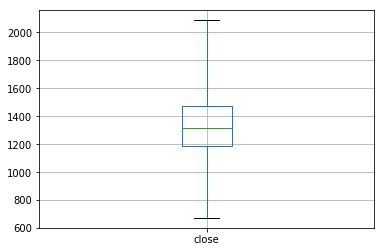

In [76]:
emini.boxplot(column='close', sym='o', whis='range', return_type='axes')

In [77]:
mean = emini['close'].mean()
median = emini['close'].median()
std = emini['close'].std()
low = emini['low'].min()
high = emini['high'].max()
price_range = high - low

print('The mean price over that timeframe was: {0:.2f}'.format(mean))
print('The median price over that timeframe was: {}'.format(median))
print('The standard deviation was: {0:.2f}'.format(std))
print('The overall price range was: {0:.2f}, from a low of {l} to a high of {h}'\
         .format(price_range, l=low, h=high))

The mean price over that timeframe was: 1349.72
The median price over that timeframe was: 1312.75
The standard deviation was: 276.18
The overall price range was: 1426.00, from a low of 662.75 to a high of 2088.75


In [37]:
emini['vol_bo_long'].value_counts()

0.0    2537
1.0      34
Name: vol_bo_long, dtype: int64

In [38]:
# Get counts for all indicators
emini_signals = emini[['vol_bo_long', 'vol_bo_short', 'range_bo_long', 'range_bo_short',
                       'ma20_long', 'ma20_short', 'ma50_long', 'ma50_short', 'ma100_long',
                       'ma100_short', 'bb_long', 'bb_short']]

In [88]:
# Get a count of each strategy signals
signal_names = [signal for signal in emini_signals.columns]
signal_counts = [emini_signals[signal].value_counts()[1] for signal in emini_signals.columns]
signal_counts

[34, 59, 536, 274, 1621, 931, 1656, 866, 1729, 743, 315, 242]

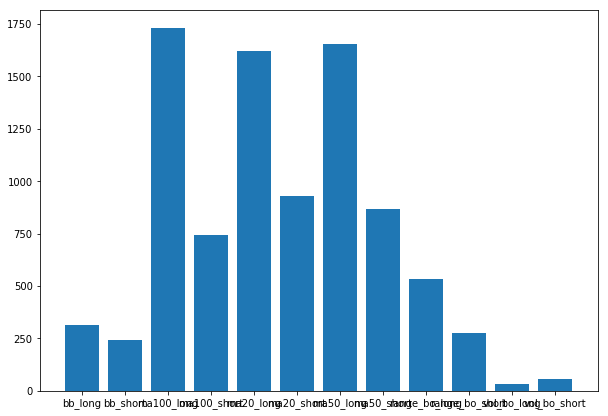

In [91]:
# Plot histogram of number of trades for different indicators
plt.figure(figsize=(10,7))

plt.bar(signal_names, signal_counts)
plt.show()

In [50]:
cpy = emini.copy()

In [54]:
# 20day historical vol column added
cpy['20day_hist_vol'] = math.sqrt(252) * cpy['pct_change_1day'].rolling(window=20, center=False).std()

In [56]:
cpy.tail()

,open,high,low,close,volume,20day_ave_vol,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,...,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day,20day_hist_vol
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-24,2078.75,2083.50,2077.00,2078.75,235054.0,1263141.32,-5.75,7.25,0.0,0.0,...,0,2111.738883,1976.291117,0,0,-0.000120,0.035105,0.029339,0.006805,0.162910
2014-12-26,2078.75,2088.75,2078.50,2084.25,614078.0,1245425.85,0.75,7.25,0.0,0.0,...,0,2114.146410,1975.518590,0,0,0.002646,0.011772,0.029768,0.007907,0.163060
2014-12-29,2086.00,2088.75,2076.00,2085.75,636306.0,1261111.33,-3.00,7.25,0.0,0.0,...,0,2117.484882,1974.690118,0,0,0.000720,0.009071,0.047852,0.012181,0.162391
2014-12-30,2087.50,2088.50,2073.00,2076.75,716610.0,1284785.30,-12.00,0.75,0.0,0.0,...,0,2120.430628,1975.069372,0,0,-0.004315,0.002051,0.047145,0.016271,0.160059
2014-12-31,2076.25,2082.75,2050.75,2052.50,835262.0,1319991.85,-36.00,-20.50,0.0,0.0,...,0,2119.972587,1974.902413,0,0,-0.011677,-0.012747,0.044529,-0.003036,0.163951


In [57]:
# Monthly historical vol calculation
montly_hist_vol = cpy['20day_hist_vol'].groupby([cpy.index.year, cpy.index.month]).mean()

In [58]:
montly_hist_vol.head()

2005  1    0.094902
      2    0.089545
      3    0.108178
      4    0.118074
      5    0.132141
Name: 20day_hist_vol, dtype: float64

In [60]:
montly_hist_vol

2005  1     0.094902
      2     0.089545
      3     0.108178
      4     0.118074
      5     0.132141
      6     0.076254
      7     0.090499
      8     0.083110
      9     0.092900
      10    0.114618
      11    0.116155
      12    0.073175
2006  1     0.094255
      2     0.098750
      3     0.080566
      4     0.081400
      5     0.106914
      6     0.153238
      7     0.136450
      8     0.098657
      9     0.072141
      10    0.066180
      11    0.068212
      12    0.077117
2007  1     0.068175
      2     0.081534
      3     0.174319
      4     0.086962
      5     0.079420
      6     0.126212
              ...   
2012  7     0.168720
      8     0.128110
      9     0.101975
      10    0.108886
      11    0.156834
      12    0.105047
2013  1     0.151412
      2     0.091943
      3     0.111889
      4     0.120372
      5     0.115221
      6     0.137190
      7     0.123524
      8     0.082827
      9     0.104863
      10    0.123907
      11    0

In [92]:
monthly_ave_price = cpy['close'].groupby([cpy.index.year, cpy.index.month]).mean()

In [93]:
monthly_ave_price

2005  1     1182.416667
      2     1200.386842
      3     1198.920455
      4     1166.761905
      5     1180.890909
      6     1207.602273
      7     1224.785714
      8     1226.969565
      9     1231.806818
      10    1195.250000
      11    1241.984091
      12    1270.107143
2006  1     1284.571429
      2     1280.327500
      3     1304.021739
      4     1308.947368
      5     1293.006522
      6     1263.613636
      7     1268.047619
      8     1292.095652
      9     1329.392857
      10    1370.602273
      11    1394.265909
      12    1428.625000
2007  1     1431.829545
      2     1450.247500
      3     1418.988636
      4     1470.904762
      5     1517.095652
      6     1528.952381
               ...     
2012  7     1355.159091
      8     1400.350000
      9     1434.687500
      10    1429.902174
      11    1390.834091
      12    1415.675000
2013  1     1475.454545
      2     1509.032500
      3     1544.500000
      4     1564.840909
      5     1636

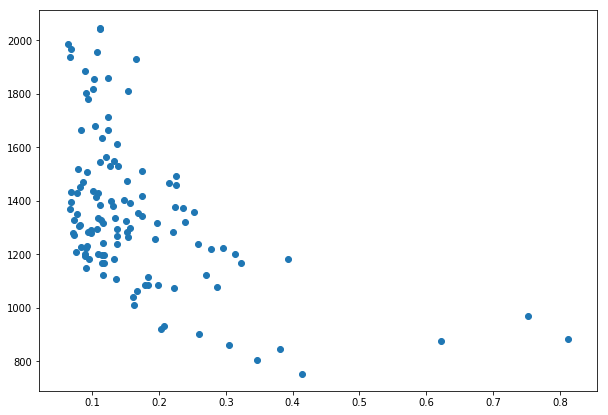

In [94]:
# Scatter plot of monthly ave price vs historical vol
plt.figure(figsize=(10,7))

plt.scatter(montly_hist_vol, monthly_ave_price)

plt.show()